# Gothic Cathedral Floorplan Generator
A very basic floor plan generator for gothic cathedral floor plans. Chatres Cathedral, Notre Dame, Duomo di Milano, Cologne Cathedral, and the Florence Cathedral were all analyzed for their core components and structure to create the underlying images that come together to create the floor plans. Some parts of the cathedrals could not be perfectly mimicked without great care, thus this is a very basic implementation. The underlying algorithm in use is Wave Function Collapse.

First, we do our necessary imports. These include image libraries and graphing tools, so that we can read in the images and create the floor plan. Also in use are XML reading and random libraries. The XML reading library is so that we may parse the rules that we have created in the rules.xml file for what pieces of the floor plan can fit together and how. The random library is for collapsing the wave function, as well as picking a starting piece.

In [1]:
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random

RULES = ET.parse("rules.xml").getroot()

POSSIBLE_STARTERS = ["topLeftCorner", "floor", "largeColumn", "smallColumn", "medColumn", "t"]

## OPTIONS : AN ARRAY OF OPTIONS TO RUN THE PROGRAM WITH
WIDTH = 20
HEIGHT = 10
SEED = random.randint(0, 10000)
RAND_STARTER = False
RAND_CORNERS = False
STARTER = "topLeftCorner"
RAND_START_POS = False
START_POS = (WIDTH // 2, HEIGHT // 2)

Next, we set up what the basics of our floor plan are going to look like. Simply, we use an x by y grid, with each space representing a tile where one of our images can go. We also choose a starting image.

In [2]:
paper = [[None]*WIDTH for i in range(HEIGHT)]

start_row = 0
start_col = 0

random.seed(SEED)

if RAND_START_POS:
    start_row = random.randint(0, HEIGHT)
    start_col = random.randint(0, WIDTH)

if RAND_STARTER and not RAND_CORNERS:
    paper[start_row][start_col] = random.choice(POSSIBLE_STARTERS)
else:
    paper[start_row][start_col] = STARTER

if not RAND_CORNERS:
    paper[0][WIDTH-1] = "topRightCorner"
    paper[HEIGHT-1][0] = "bottomLeftCorner"
    paper[HEIGHT-1][WIDTH-1] = "bottomRightCorner"

Here we create a couple of functions that help us get the possible options for what to place into a tile. The get_options method checks the neighboring tiles and then tells the helper method what to look for based on the neighbors it finds. It also makes a call to remove uniques which returns a list where everything in the list only occurs once, and can only occur if it reaches approval from each neighbor (occurs the number of neighbors that exist times).

In [3]:
def remove_uniques(lst, threshold):
    ret = []

    for item in lst:
        if lst.count(item) >= threshold and item not in ret:
            ret.append(item)

    return ret

def get_options_helper(neighbor, direction):
    options = []

    for tile in RULES:
        if tile.get("name") == neighbor:
            for rule in tile:
                directions = rule.get("directions")
                if directions != None and direction in directions:
                    options.append(rule.get("name"))

    return options


def get_options(row, col):
    options = []
    min_accept = 0

    if row == 0 or paper[row-1][col] != None: ## North
        neighbor = paper[row-1][col] if row != 0 else "northBorder"

        min_accept += 1
        options += get_options_helper(neighbor, "south")

    if col + 1 == WIDTH or paper[row][col+1] != None: ## East
        neighbor = paper[row][col+1] if col + 1 < WIDTH else "eastBorder"

        min_accept += 1
        options += get_options_helper(neighbor, "west")

    if row + 1 == HEIGHT or paper[row+1][col] != None: ## South
        neighbor = paper[row+1][col] if row + 1 < HEIGHT else "southBorder"

        min_accept += 1
        options += get_options_helper(neighbor, "north")

    if col == 0 or paper[row][col-1] != None: ## West
        neighbor = paper[row][col-1] if col != 0 else "westBorder"

        min_accept += 1
        options += get_options_helper(neighbor, "east")

    return remove_uniques(options, min_accept)

def get_num_neighbors(row, col):
    neighbor = 0

    if row == 0 or paper[row-1][col] != None: ## North
        neighbor += 1

    if col + 1 == WIDTH or paper[row][col+1] != None: ## East
        neighbor += 1

    if row + 1 == HEIGHT or paper[row+1][col] != None: ## South
        neighbor += 1

    if col == 0 or paper[row][col-1] != None: ## West
        neighbor += 1

    return neighbor


Now we have to figure out how many options each tile has. Whichever tile has the fewest options at the end, is the one that we collapse. If there is a tie, we can either choose randomly, or pick the first or last one we come across. We keep track of these options in a 2D array similar to the one that we set up to house our tiles. If a tile has no neighbors, we consider that there are no limitations on what that tile can be, so we only worry about the ones with at least one neighbor; of which, since we set our starting tile at the beginning, there is at least one. If we get to a point where there are any tiles with no possible options, we restart. This continues until we've completely filled up our array and have completed the floor plan.

In [4]:
change = True
saved_paper_state = [row[:] for row in paper]

while (change):
    change = False
    DEFAULT_OPTIONS = 15 ## How many options there are if no neighbor tiles

    option_count = [[DEFAULT_OPTIONS]*WIDTH for i in range(HEIGHT)]

    for row in range(HEIGHT):
        for col in range(WIDTH):
            if paper[row][col] != None:
                option_count[row][col] = paper[row][col]
                continue
            
            if get_num_neighbors(row, col) != 0:
                option_count[row][col] = get_options(row, col)

    smallest_row = 0
    smallest_col = 0
    fewest_options = DEFAULT_OPTIONS

    for row in range(HEIGHT):
        for col in range(WIDTH):
            if type(option_count[row][col]) == list and len(option_count[row][col]) <= fewest_options:
                change = True
                fewest_options = len(option_count[row][col])
                smallest_row = row
                smallest_col = col

    try:
        paper[smallest_row][smallest_col] = random.choice(option_count[smallest_row][smallest_col]) if change else paper[smallest_row][smallest_col]
    except:
        paper = [row[:] for row in saved_paper_state]
        SEED = random.randint(0, 10000)
        random.seed(SEED)

Finally, we draw out our newly generated floor plan. The drawing is currenlty optimized for 20 x 10 floor plans, so anything else the vertical spacing might be a bit off.

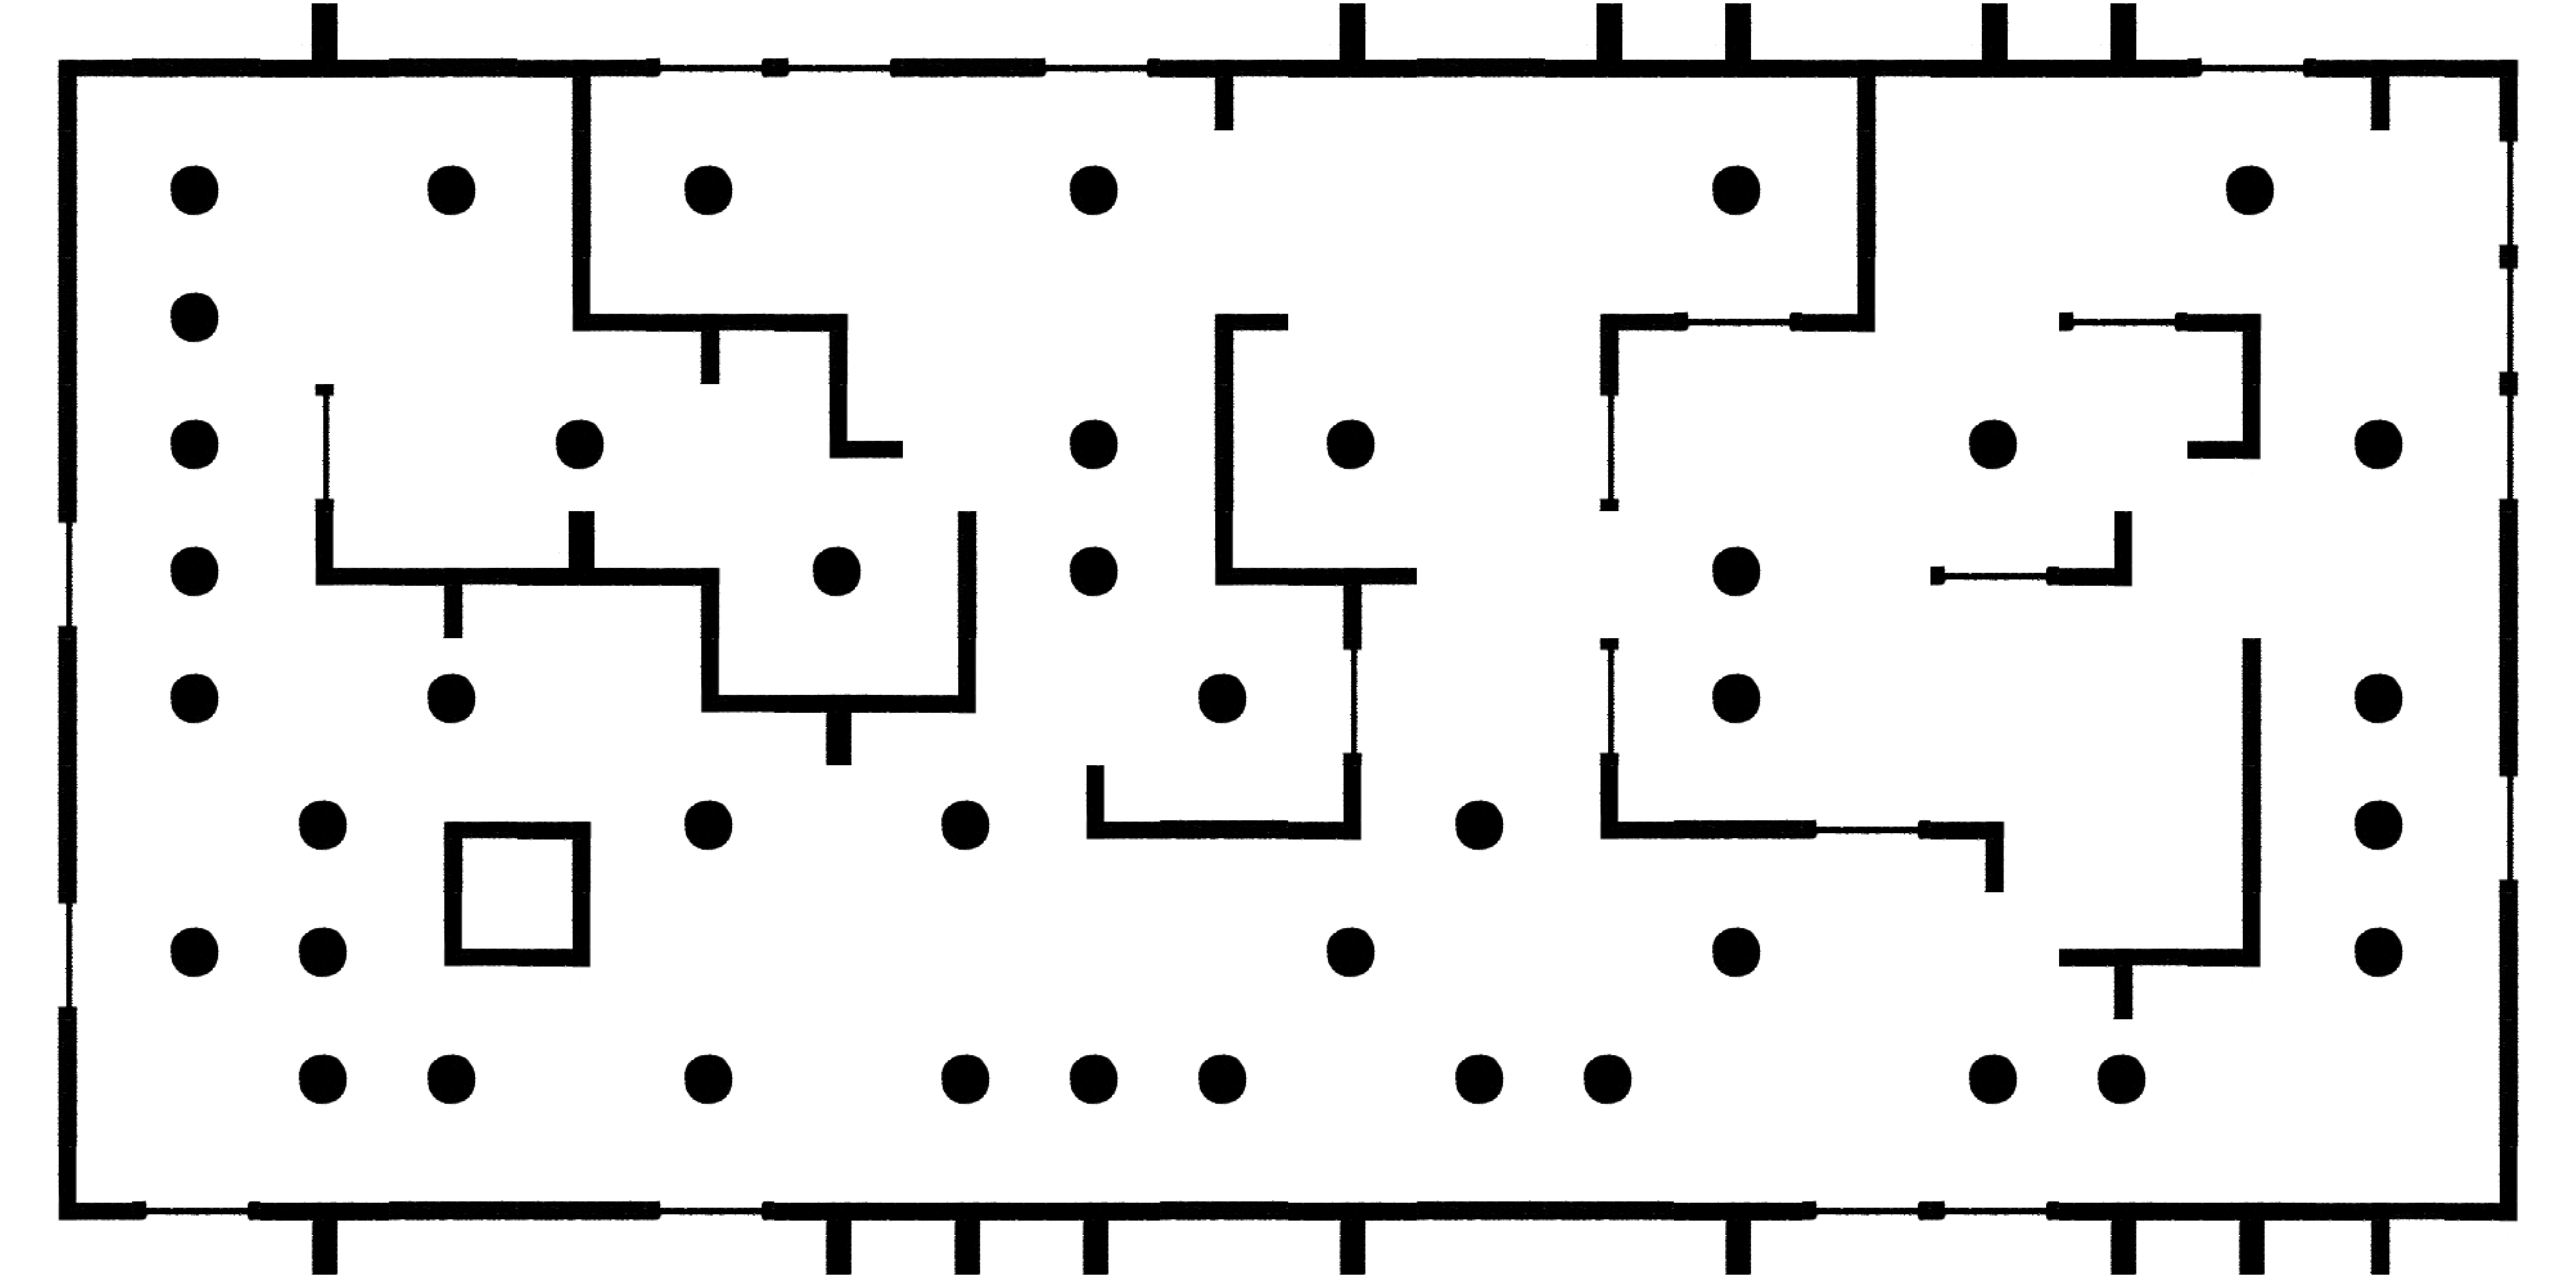

In [5]:
plot = plt.figure(figsize=(100, 100))

plt.subplots_adjust(wspace=0, hspace=-.91)

counter = 0
for i in range(HEIGHT):
    for j in range(WIDTH):
        counter += 1
        sub = plot.add_subplot(HEIGHT, WIDTH, counter)
        sub.axis("off")
        sub.margins(x=0)
        sub.imshow(Image.open("img/" + paper[i][j] + ".bmp"))